In [1]:
#### image version
#### https://core.ac.uk/download/pdf/201006092.pdf.
#### Iacovacci, J., & Lacasa, L. (2019). Visibility graphs for image processing. 
#### IEEE transactions on pattern analysis and machine intelligence, 42(4), 974-987.

In [2]:
import numpy as np
import cv2
from numpy.lib.stride_tricks import as_strided
import matplotlib.pyplot as plt

def _extract_patches_2d(img: np.ndarray, k: int):
    """Devuelve una vista con forma (H-k+1, W-k+1, k, k) sin copiar."""
    H, W = img.shape
    out_shape = (H - k + 1, W - k + 1, k, k)
    s0, s1 = img.strides
    out_strides = (s0, s1, s0, s1)
    return as_strided(img, shape=out_shape, strides=out_strides, writeable=False)

def _visibility_line(lines: np.ndarray):
    """
    lines: (..., k) valores
    Regresa booleanos (...,) para el predicado:
       x1 < x0  AND  x2>x1 AND x3>x2 ... (estrictamente creciente desde x1)
    """
    k = lines.shape[-1]
    if k < 3:
        raise ValueError("order (k) debe ser >= 3.")
    # x1 < x0
    start_ok = lines[..., 1] < lines[..., 0]
    # x2>x1, x3>x2, ...
    if k == 3:
        grow_ok = lines[..., 2] > lines[..., 1]
    else:
        grow_ok = np.all(lines[..., 2:] > lines[..., 1:-1], axis=-1)
    return start_ok & grow_ok

def patch_profile_visibility_vectorized(img: np.ndarray, order: int = 3):
    """
    Perfil de visibilidad por parches k×k (k=order) vectorizado.

    Parámetros
    ----------
    img   : np.ndarray (H, W), escala de grises
    order : int >= 3, tamaño del parche k

    Retorna
    -------
    Z     : np.ndarray (2**T + 1,), histograma (índice 0 sin uso)
    Lmap  : np.ndarray (H-k+1, W-k+1), etiqueta en [1, 2**T]
    """
    if img.ndim != 2:
        raise ValueError("img debe ser 2D (escala de grises).")
    k = int(order)
    if k < 3:
        raise ValueError("order debe ser >= 3.")
    H, W = img.shape
    if H < k or W < k:
        raise ValueError(f"La imagen debe ser al menos de {k}×{k} píxeles.")

    I = img.astype(np.int64, copy=False)
    patches = _extract_patches_2d(I, k)  # (H', W', k, k)
    Hp, Wp = patches.shape[:2]

    # --- Construir todas las líneas a evaluar (en bloque) ---
    # Filas: k líneas por parche → shape (H', W', k, k)
    row_lines = patches  # cada ...[r, :] es una fila
    # Columnas: k líneas por parche → (H', W', k, k)
    col_lines = np.swapaxes(patches, -1, -2)  # para que ...[c, :] sea la columna c
    # Diagonal principal: (..., k)
    idx = np.arange(k)
    diag_main = patches[..., idx, idx]
    # Diagonal secundaria: (..., k)
    diag_anti = patches[..., idx, k - 1 - idx]

    # --- Evaluar el predicado en bloque ---
    # Para filas/columnas queremos un booleano por fila/columna.
    row_ok = _visibility_line(row_lines)            # (H', W', k)
    col_ok = _visibility_line(col_lines)            # (H', W', k)
    d1_ok  = _visibility_line(diag_main)            # (H', W')
    d2_ok  = _visibility_line(diag_anti)            # (H', W')

    # --- Empaquetar bits en el orden: filas(0..k-1), columnas(0..k-1), diag_main, diag_anti ---
    T = 2 * k + 2
    Vbits = np.zeros((Hp, Wp, T), dtype=np.uint8)
    Vbits[:, :, :k] = row_ok
    Vbits[:, :, k:2*k] = col_ok
    Vbits[:, :, 2*k] = d1_ok
    Vbits[:, :, 2*k + 1] = d2_ok

    # Convertir bits → entero (bit más significativo = test 0)
    # L = 1 + sum V[i] * 2**(T-1-i)
    powers = (1 << np.arange(T-1, -1, -1, dtype=np.int64))  # (T,)
    labels_0based = (Vbits.astype(np.int64) * powers).sum(axis=-1)  # (H', W')
    Lmap = (labels_0based + 1).astype(np.int32)

    # Histograma (índice 0 sin uso para mantener compatibilidad con pseudocódigo)
    Z = np.bincount(Lmap.ravel(), minlength=(1 << T) + 1)
    # Aseguramos longitud exacta
    if Z.size < (1 << T) + 1:
        Z = np.pad(Z, (0, (1 << T) + 1 - Z.size), constant_values=0)

    return Z, Lmap

In [3]:
from numpy.lib.stride_tricks import as_strided

def _valid_window_mask(mask: np.ndarray, k: int) -> np.ndarray:
    """
    Devuelve una máscara 2D de forma (H-k+1, W-k+1) donde True indica
    que la ventana k×k está COMPLETAMENTE dentro del disco (mask=1).
    """
    H, W = mask.shape
    if H < k or W < k:
        raise ValueError(f"Imagen/máscara muy pequeña para k={k}.")
    m = mask.astype(np.uint8, copy=False)
    # ventanas k×k sin copia
    s0, s1 = m.strides
    wins = as_strided(m, shape=(H-k+1, W-k+1, k, k), strides=(s0, s1, s0, s1), writeable=False)
    # válido si todos los k*k píxeles son 1
    valid = (wins.sum(axis=(2,3)) == (k*k))
    return valid

def _ivg_hist_masked(A_float01: np.ndarray, mask: np.ndarray, order: int, hellinger: bool = True):
    """
    Igual lógica que _ivg_hist_normalized, pero:
    - Calcula Lmap con patch_profile_visibility_vectorized.
    - Hace histograma SOLO sobre ventanas k×k 100% dentro del disco.
    """
    k = int(order)
    # 1) etiquetas completas en toda la imagen
    Z_all, Lmap = patch_profile_visibility_vectorized((A_float01*255).astype(np.uint8), order=k)
    # 2) máscara de ventanas válidas (top-left positions) para k
    valid = _valid_window_mask(mask, k)   # (H-k+1, W-k+1)
    L_valid = Lmap[valid]
    # 3) histograma solo con válidos
    T = 2*k + 2
    Z = np.bincount(L_valid.ravel(), minlength=(1 << T) + 1)
    h = Z[1:].astype(np.float64)
    s = h.sum()
    if s > 0:
        h /= s              # L1
    if hellinger:
        h = np.sqrt(h)      # Hellinger
    return h

In [4]:
# -----------------------------------------------------------------------------
# IVG-HMI • Dataset constructor
#   - Descarga HMI 1024 (12:00 UT) por rango de fechas
#   - Enmascara/normaliza el disco
#   - Extrae histogramas IVG normalizados para órdenes k = 3/4/5
#   - Devuelve un DataFrame con la fecha/hora y los Z concatenados
# Requiere: patch_profile_visibility_vectorized(img, order) definido previamente
# -----------------------------------------------------------------------------

from datetime import date, datetime, timedelta
from io import BytesIO
import requests
import numpy as np
import pandas as pd
from PIL import Image

BASE = "https://soho.nascom.nasa.gov/data/REPROCESSING/Completed"

def build_hmi_url(d: date) -> str:
    y = d.strftime("%Y")
    ymd = d.strftime("%Y%m%d")
    # 12:00 UT fijo según tu especificación
    return f"{BASE}/{y}/hmiigr/{ymd}/{ymd}_1200_hmiigr_1024.jpg"

import time
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

def _get_session(total_retries=3, backoff=0.5):
    s = requests.Session()
    # reintentos en 429/5xx, con backoff exponencial
    retry = Retry(
        total=total_retries,
        read=total_retries,
        connect=total_retries,
        backoff_factor=backoff,
        status_forcelist=(429, 500, 502, 503, 504),
        allowed_methods=frozenset(["GET", "HEAD"])
    )
    s.mount("https://", HTTPAdapter(max_retries=retry))
    s.headers.update({
        "User-Agent": "IVG-HMI/0.1 (academic; contact: you@example.org)"
    })
    return s

_SESSION = _get_session()

def fetch_hmi_image(d: date, timeout=20, as_gray=True, session=None, polite_pause=0.0):
    """
    Descarga en memoria la imagen HMI del día d.
    Devuelve: PIL.Image (L si as_gray=True) o None si no existe/no es imagen válida.
    """
    if session is None:
        session = _SESSION
    url = build_hmi_url(d)
    try:
        r = session.get(url, timeout=timeout, stream=True)
        # Verifica status
        if r.status_code != 200:
            return None
        # Verifica Content-Type (debe empezar con image/)
        ctype = r.headers.get("Content-Type", "").lower()
        content = r.raw.read()  # usamos stream para no descargar dos veces
        # Chequea magia JPEG (FF D8 FF) por si el header miente
        is_jpeg_magic = len(content) > 3 and content[0:3] == b"\xff\xd8\xff"
        if not (ctype.startswith("image/") or is_jpeg_magic):
            return None

        img = Image.open(BytesIO(content))
        # Asegura carga completa (evita lazy decoding)
        img.load()
        if as_gray:
            img = img.convert("L")
        # Pausa educada si se pide
        if polite_pause > 0:
            time.sleep(polite_pause)
        return img
    except Exception:
        # cualquier falla (incl. UnidentifiedImageError) → None
        return None
        
def solar_disk_mask(img: Image.Image, thresh=8, margin=2):
    A = np.asarray(img, dtype=np.uint8)
    H, W = A.shape[:2]
    m = A > thresh
    if m.sum() < 1000:
        cy, cx = (H-1)/2.0, (W-1)/2.0
        R = min(H, W)//2 - margin
    else:
        ys, xs = np.nonzero(m)
        cy, cx = ys.mean(), xs.mean()
        R = np.percentile(np.hypot(ys - cy, xs - cx), 99) - margin
        R = max(1.0, float(R))
    yy, xx = np.ogrid[:H, :W]
    mask = ((yy - cy)**2 + (xx - cx)**2) <= (R**2)
    return mask.astype(np.uint8)

def apply_mask(img: Image.Image, mask: np.ndarray, fill=0):
    A = np.asarray(img, dtype=np.float32)
    A_out = np.where(mask, A, fill)
    inside = A_out[mask.astype(bool)]
    if inside.size > 0:
        p2, p98 = np.percentile(inside, [2, 98])
        if p98 > p2:
            A_out = np.clip((A_out - p2) / (p98 - p2), 0, 1)
        else:
            A_out = A_out / (inside.max() + 1e-6)
    else:
        A_out = A_out / 255.0
    return A_out

def daterange(start: date, end: date):
    d = start
    one = timedelta(days=1)
    while d <= end:
        yield d
        d += one

def _ivg_hist_normalized(A_float01: np.ndarray, order: int, hellinger: bool = True):
    """
    Calcula Z para 'order' y devuelve histograma normalizado (descartando índice 0).
    """
    # La función patch_profile_visibility_vectorized requiere enteros (comparaciones estricto):
    Z, _ = patch_profile_visibility_vectorized((A_float01*255).astype(np.uint8), order=order)
    h = Z[1:].astype(np.float64)
    s = h.sum()
    if s > 0:
        h /= s          # L1
    if hellinger:
        h = np.sqrt(h)  # Hellinger
    return h

# --- añade esta función antes (la que te pasé) ---
import numpy as np
from numpy.linalg import lstsq

def limb_darkening_flatten(A, mask, deg=4):
    """
    A: float [0,1] enmascarada (fondo 0); mask: {0,1}
    Ajusta un polinomio 2D (grado 'deg') en el disco y divide A por ese modelo.
    Devuelve imagen "aplanada" reescalada a [0,1].
    """
    H, W = A.shape
    y, x = np.nonzero(mask)
    if y.size < 1000:
        return A  # por si la máscara falló

    yy = (y - (H-1)/2)/((H-1)/2)
    xx = (x - (W-1)/2)/((W-1)/2)

    # base polinómica 2D hasta 'deg'
    Phi = [np.ones_like(xx)]
    for i in range(1, deg+1):
        for j in range(i+1):
            Phi.append((xx**j) * (yy**(i-j)))
    Phi = np.vstack(Phi).T
    b = A[y, x]
    coef, *_ = lstsq(Phi, b, rcond=None)

    Y, X = np.ogrid[:H, :W]
    yy2 = (Y - (H-1)/2)/((H-1)/2)
    xx2 = (X - (W-1)/2)/((W-1)/2)
    Phi_full = [np.ones_like(xx2, dtype=float)]
    for i in range(1, deg+1):
        for j in range(i+1):
            Phi_full.append((xx2**j) * (yy2**(i-j)))
    model = sum(c*m for c, m in zip(coef, Phi_full))

    # divide y reescala robustamente en el disco
    flat = A / (model + 1e-6)
    inside = flat[mask.astype(bool)]
    p2, p98 = np.percentile(inside, [2, 98])
    if p98 > p2:
        flat = np.clip((flat - p2) / (p98 - p2), 0, 1)
    else:
        flat = flat / (inside.max() + 1e-6)
    return flat


def build_ivg_dataset(start: date,
                      end: date,
                      orders=(3,),
                      hellinger: bool = True,
                      thresh: int = 8,
                      margin: int = 2,
                      drop_missing: bool = True,
                      polite_pause: float = 0.1,
                      session=None,
                      apply_ld: bool = True,   # << nuevo
                      ld_deg: int = 4):        # << nuevo
    if isinstance(orders, int):
        orders = (orders,)
    orders = tuple(int(k) for k in orders)

    if session is None:
        session = _SESSION

    rows = []
    colnames = None
    missing = []

    for d in daterange(start, end):
        if d.day == 1:
            print(f"[{d}]")
        img = fetch_hmi_image(d, session=session, polite_pause=polite_pause)
        if img is None:
            missing.append(d)
            if not drop_missing:
                rows.append({"datetime": datetime(d.year, d.month, d.day, 12, 0)})
            continue

        mask = solar_disk_mask(img, thresh=thresh, margin=margin)
        A = apply_mask(img, mask, fill=0)

        # >>>>>>> AQUI SE APLICA EL LIMB DARKENING <<<<<<<
        if apply_ld:
            A = limb_darkening_flatten(A, mask, deg=ld_deg)

        feats = []
        for k in orders:
            #h = _ivg_hist_normalized(A, order=k, hellinger=hellinger)
            h = _ivg_hist_masked(A, mask, order=k, hellinger=hellinger)
            feats.append(h)
        fvec = np.concatenate(feats)

        if colnames is None:
            names = []
            for k in orders:
                T = 2*k + 2
                nbins = 2**T
                names.extend([f"k{k}_b{b:03d}" for b in range(1, nbins+1)])
            colnames = ["datetime"] + names

        row = {"datetime": datetime(d.year, d.month, d.day, 12, 0)}
        row.update({name: float(val) for name, val in zip(colnames[1:], fvec)})
        rows.append(row)

    df = pd.DataFrame(rows, columns=colnames if colnames is not None else None)

    if missing:
        # muestra algunos ejemplos para depurar
        sample = ", ".join([m.strftime("%Y-%m-%d") for m in missing[:5]])
        tail = " ..." if len(missing) > 5 else ""
        print(f"[INFO] Fechas sin imagen válida: {len(missing)} → {sample}{tail}")

    print(f"[OK] Dataset: {len(df)} filas, {df.shape[1]-1 if df is not None else 0} features; "
          f"faltantes omitidos: {len(missing)}")

    return df

In [124]:
year=2025
# ----------------------------- USO para generación --------------------------------
if __name__ == "__main__":
    # Rango corto de ejemplo
    start = date(year, 1, 1)
    end   = date(year, 12, 31)

    # a1) Solo orden 3 (256 bins)
    #df_k3 = build_ivg_dataset(start, end, orders=3)
    #print(df_k3.head())
    #df_k3.to_csv("ivg_hmi_k3.csv", index=False)
    # a2) Solo orden 4 (1024 bins)
    #df_k4 = build_ivg_dataset(start, end, orders=4)
    #print(df_k4.head())
    #df_k4.to_csv("ivg_hmi_k4.csv", index=False)
    # b) Órdenes 3 y 4 concatenados (256 + 1024 bins)
    df_k34 = build_ivg_dataset(start, end, orders=(3,4))
    #print(df_k34.shape)  # filas × (1 + 1280)
    df_k34.to_csv("ivg_hmi_k34_{}.csv".format(str(year)), index=False)

[2025-01-01]
[2025-02-01]
[2025-03-01]
[2025-04-01]
[2025-05-01]
[2025-06-01]
[2025-07-01]
[2025-08-01]
[2025-09-01]
[2025-10-01]
[2025-11-01]
[2025-12-01]
[INFO] Fechas sin imagen válida: 63 → 2025-01-01, 2025-01-02, 2025-01-03, 2025-01-04, 2025-01-05 ...
[OK] Dataset: 302 filas, 1280 features; faltantes omitidos: 63


In [8]:
df_k34.head(3)

datetime   k3_b001   k3_b002   k3_b003  k3_b004   k3_b005  \
0 2012-01-01 12:00:00  0.405028  0.092192  0.092449      0.0  0.215257   
1 2012-01-02 12:00:00  0.405497  0.093046  0.093203      0.0  0.215523   
2 2012-01-03 12:00:00  0.406984  0.093075  0.093672      0.0  0.214861   

    k3_b006   k3_b007  k3_b008   k3_b009  ...  k4_b1015  k4_b1016  k4_b1017  \
0  0.064965  0.064394      0.0  0.138749  ...  0.000000       0.0       0.0   
1  0.066068  0.063530      0.0  0.138763  ...  0.000000       0.0       0.0   
2  0.065272  0.065411      0.0  0.137506  ...  0.001182       0.0       0.0   

   k4_b1018  k4_b1019  k4_b1020  k4_b1021  k4_b1022  k4_b1023  k4_b1024  
0       0.0  0.001182  0.001182       0.0       0.0  0.000000  0.001672  
1       0.0  0.000000  0.000000       0.0       0.0  0.000000  0.000000  
2       0.0  0.002047  0.000000       0.0       0.0  0.001182  0.000000  

[3 rows x 1281 columns]

In [6]:
# -------------------------------------------------------------
# Figura "triptych" para el paper: Original • Máscara • Disco normalizado
# Requiere que ya existan: fetch_hmi_image, solar_disk_mask, apply_mask
# Guarda PNG en alta resolución (300 dpi) listo para insertar en el manuscrito
# -------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

def plot_hmi_triptych(d: date,
                      thresh=8, margin=2,
                      cmap="gray",
                      dpi=300,
                      savepath=None,
                      show=True):
    """
    d: fecha (datetime.date) a las 12:00 UT
    savepath: ruta para guardar (p.ej. 'fig_hmi_triptych_20110101.png')
    """
    img = fetch_hmi_image(d)
    if img is None:
        raise RuntimeError(f"No se pudo descargar la imagen del {d}")

    # Máscara y normalización
    mask = solar_disk_mask(img, thresh=thresh, margin=margin)
    A = apply_mask(img, mask, fill=0)  # float [0,1]

    # Figura 3 paneles
    fig, axs = plt.subplots(1, 3, figsize=(9.0, 3.2))
    # 1) Original + contorno
    axs[0].imshow(img, cmap=None, vmin=0, vmax=255)
    axs[0].contour(mask, colors="r", linewidths=0.6)
    axs[0].set_title(f"Original — {d.isoformat()} 12:00 UT")
    axs[0].axis("off")

    # 2) Máscara
    axs[1].imshow(mask, cmap="gray")
    axs[1].set_title("Disk mask")
    axs[1].axis("off")

    # 3) Enmascarada/normalizada
    axs[2].imshow(A, cmap=cmap, vmin=0, vmax=1)
    axs[2].set_title("Masked Disk/Normalized")
    axs[2].axis("off")

    plt.tight_layout()
    if savepath is None:
        savepath = f"fig_hmi_triptych_{d.strftime('%Y%m%d')}.png"
    fig.savefig(savepath, dpi=dpi, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close(fig)
    print(f"[OK] Figura guardada en: {savepath}")

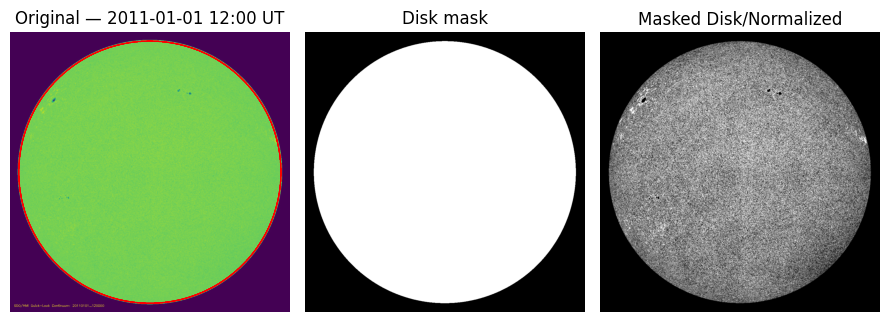

[OK] Figura guardada en: fig_hmi_triptych_20110101.png


In [7]:
plot_hmi_triptych(date(2011, 1, 1), savepath="fig_hmi_triptych_20110101.png")

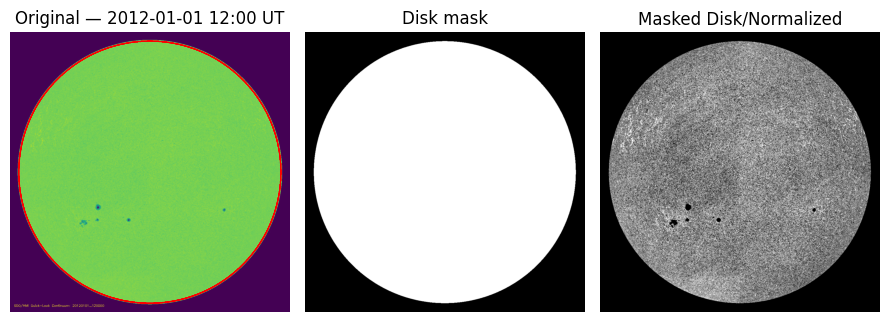

[OK] Figura guardada en: fig_hmi_triptych_20120101.png


In [8]:
plot_hmi_triptych(date(2012, 1, 1), savepath="fig_hmi_triptych_20120101.png")

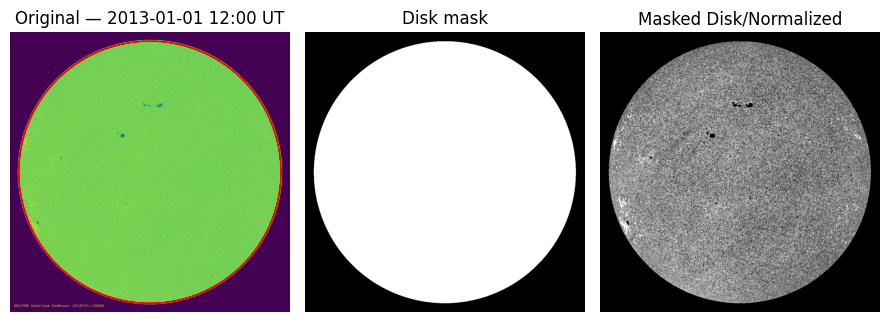

[OK] Figura guardada en: fig_hmi_triptych_20130101.png


In [9]:
plot_hmi_triptych(date(2013, 1, 1), savepath="fig_hmi_triptych_20130101.png")

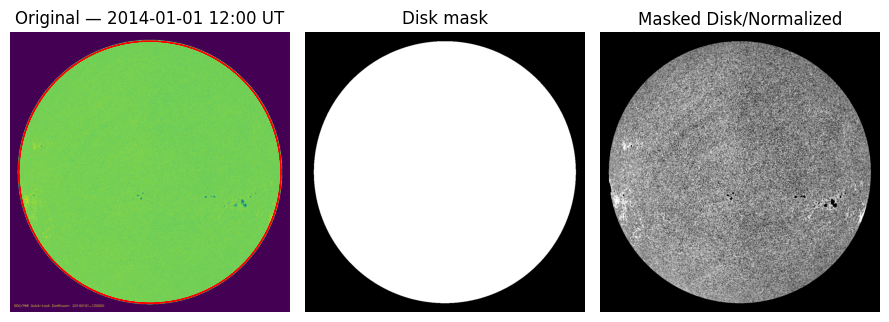

[OK] Figura guardada en: fig_hmi_triptych_20140101.png


In [10]:
plot_hmi_triptych(date(2014, 1, 1), savepath="fig_hmi_triptych_20140101.png")

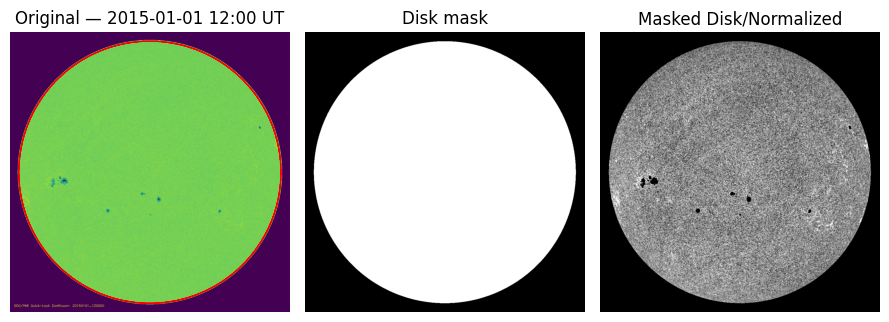

[OK] Figura guardada en: fig_hmi_triptych_20150101.png


In [11]:
plot_hmi_triptych(date(2015, 1, 1), savepath="fig_hmi_triptych_20150101.png")

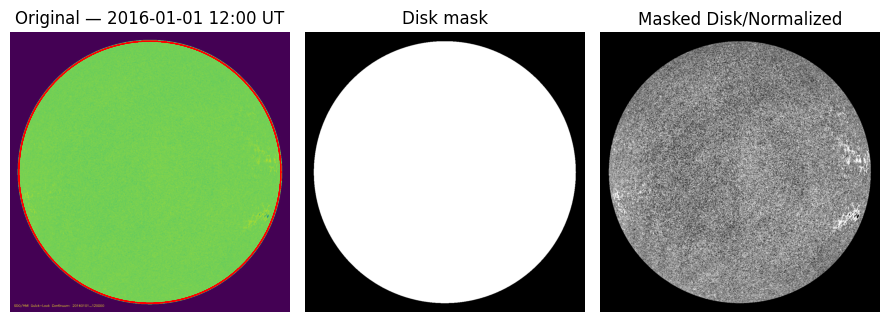

[OK] Figura guardada en: fig_hmi_triptych_20160101.png


In [12]:
plot_hmi_triptych(date(2016, 1, 1), savepath="fig_hmi_triptych_20160101.png")

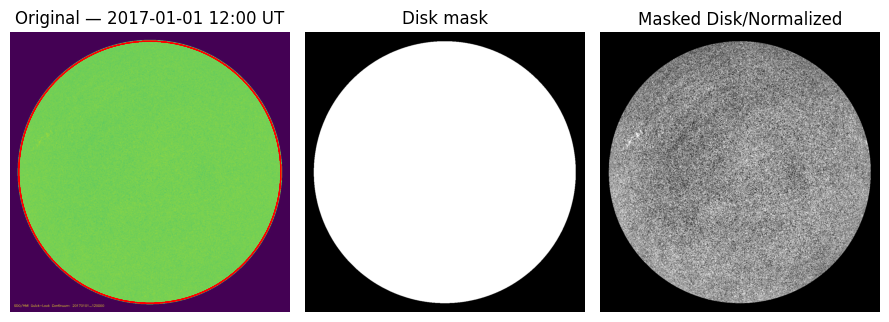

[OK] Figura guardada en: fig_hmi_triptych_20170101.png


In [13]:
plot_hmi_triptych(date(2017, 1, 1), savepath="fig_hmi_triptych_20170101.png")

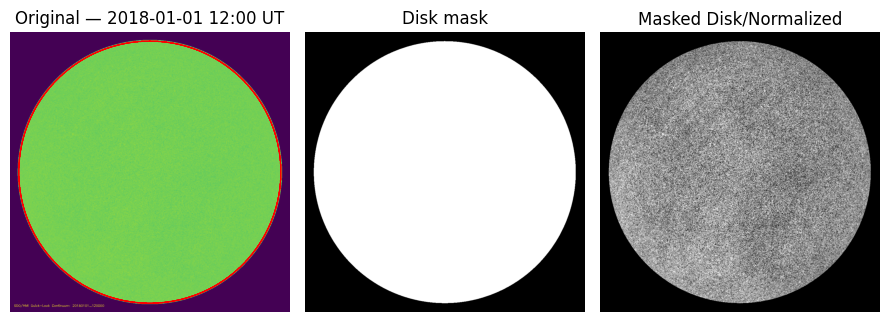

[OK] Figura guardada en: fig_hmi_triptych_20180101.png


In [14]:
plot_hmi_triptych(date(2018, 1, 1), savepath="fig_hmi_triptych_20180101.png")

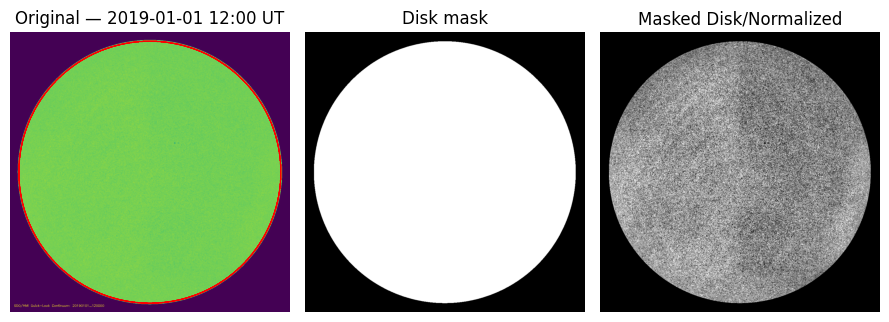

[OK] Figura guardada en: fig_hmi_triptych_20190101.png


In [15]:
plot_hmi_triptych(date(2019, 1, 1), savepath="fig_hmi_triptych_20190101.png")

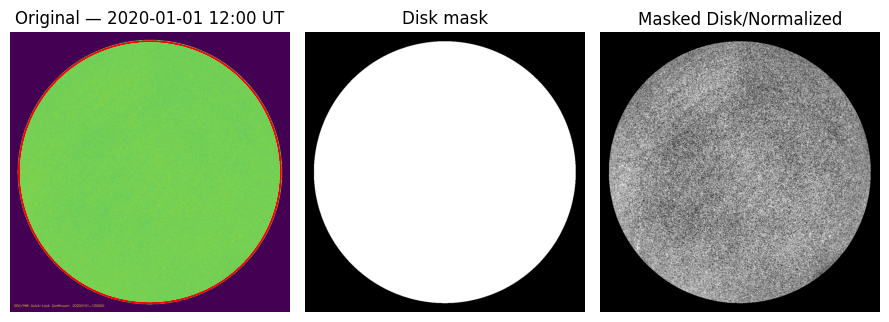

[OK] Figura guardada en: fig_hmi_triptych_20200101.png


In [16]:
plot_hmi_triptych(date(2020, 1, 1), savepath="fig_hmi_triptych_20200101.png")

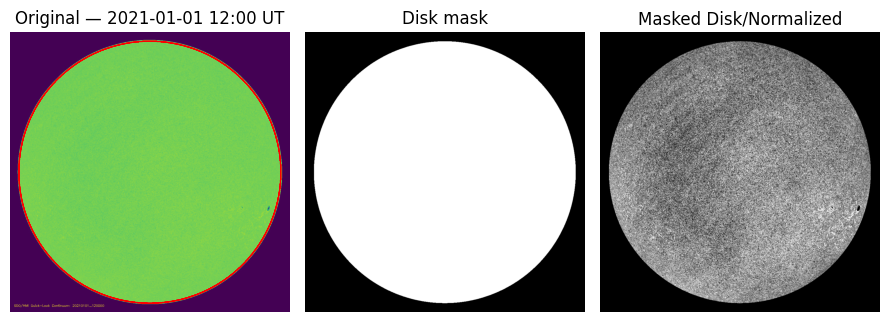

[OK] Figura guardada en: fig_hmi_triptych_20210101.png


In [17]:
plot_hmi_triptych(date(2021, 1, 1), savepath="fig_hmi_triptych_20210101.png")

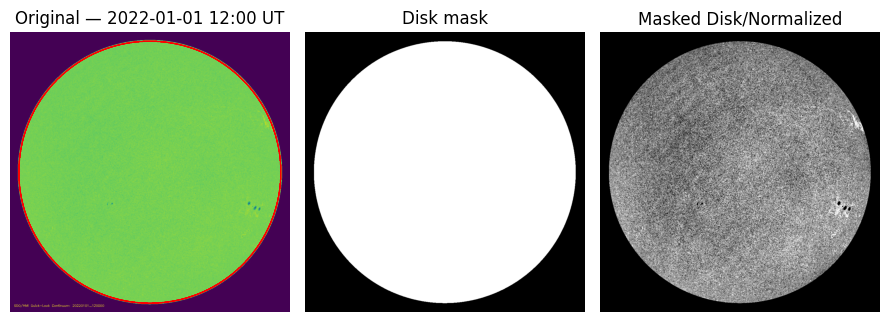

[OK] Figura guardada en: fig_hmi_triptych_20220101.png


In [18]:
plot_hmi_triptych(date(2022, 1, 1), savepath="fig_hmi_triptych_20220101.png")

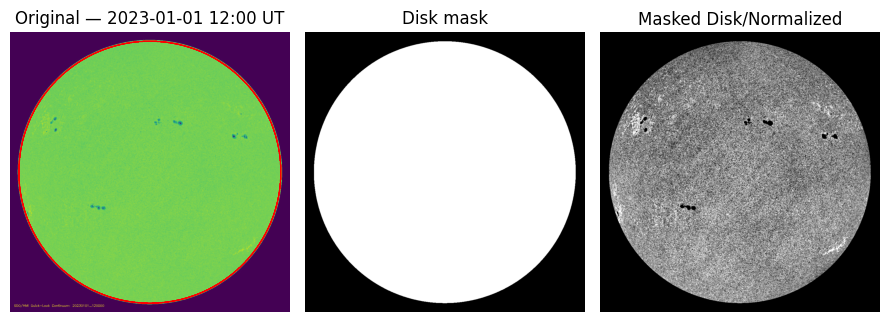

[OK] Figura guardada en: fig_hmi_triptych_20230101.png


In [19]:
plot_hmi_triptych(date(2023, 1, 1), savepath="fig_hmi_triptych_20230101.png")

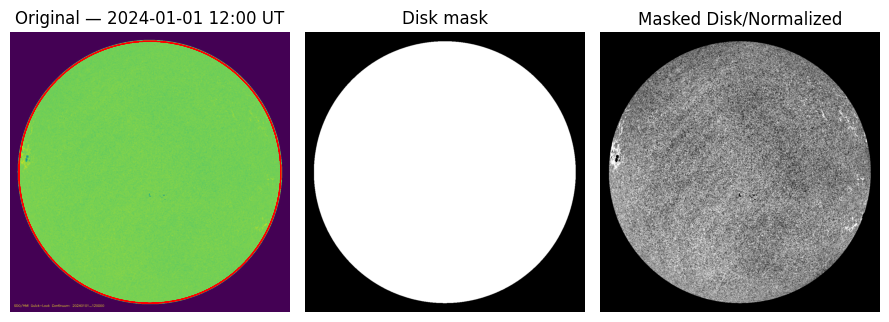

[OK] Figura guardada en: fig_hmi_triptych_20240101.png


In [20]:
plot_hmi_triptych(date(2024, 1, 1), savepath="fig_hmi_triptych_20240101.png")

## Mejorres imágenes, más paneles....

In [106]:
# -------------------------------------------------------------
# Figura multi-panel para el paper: Original • Máscara • Disco(s) • Lmap • Hist(Z_k)
# Requiere: fetch_hmi_image, solar_disk_mask, apply_mask,
#           patch_profile_visibility_vectorized,
#           limb_darkening_flatten, _valid_window_mask, _ivg_hist_masked
# -------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

def _compute_lmap_valid(A_float01, mask, k):
    """
    Devuelve (Lmap, valid_win) para order=k.
    Lmap: etiquetas IVG en forma (H-k+1, W-k+1)
    valid_win: boolean (H-k+1, W-k+1) True si la ventana k×k está 100% dentro del disco
    """
    # Lmap completo (en toda la imagen)
    _, Lmap = patch_profile_visibility_vectorized((A_float01*255).astype(np.uint8), order=k)
    # ventanas válidas (solo top-left donde k×k cabe en el disco)
    valid_win = _valid_window_mask(mask, k)
    return Lmap, valid_win

def plot_hmi_multipanel(d: date,
                        orders=(3,),              # puedes pasar (3,) o (3,4)
                        show_ld=True,             # panel de limb-darkening flatten
                        hellinger=True,
                        thresh=8, margin=2,
                        top_bins=20,              # Top-N bins en el histograma
                        cmap_img="gray",
                        cmap_lmap="viridis",
                        dpi=300,
                        savepath=None,
                        show=True):
    """
    d: fecha (datetime.date) 12:00 UT
    orders: tuple de órdenes k a reportar (usa el primero para Lmap+hist)
    show_ld: añade panel con disco "flattened" por limb-darkening
    hellinger: normaliza hist con L1 y aplica sqrt (Hellinger) si True
    top_bins: cuántas etiquetas mostrar en el barplot (ordenadas por peso)
    """
    img = fetch_hmi_image(d)
    if img is None:
        raise RuntimeError(f"No se pudo descargar la imagen del {d}")

    # Máscara y normalización básica
    mask = solar_disk_mask(img, thresh=thresh, margin=margin)
    A = apply_mask(img, mask, fill=0)  # float [0,1]

    # Limb-darkening flatten (opcional)
    A_ld = limb_darkening_flatten(A, mask, deg=4) if show_ld else None

    # Elegimos un k "principal" para Lmap e histograma (el primero de 'orders')
    k0 = int(orders[0])

    # Histograma Z_k0 (solo parches válidos)
    Zk = _ivg_hist_masked(A if not show_ld else A_ld, mask, order=k0, hellinger=hellinger)

    # Prepara Lmap (visualizando solo ventanas válidas)
    Lmap, valid = _compute_lmap_valid(A if not show_ld else A_ld, mask, k0)
    Lvis = np.full_like(Lmap, np.nan, dtype=float)
    Lvis[valid] = Lmap[valid].astype(float)

    # ----- Layout de paneles -----
    # Base: 3 paneles (Original, Mask, Disco). +1 si LD, +1 Lmap, +1 hist = 5–6 paneles
    n_pan = 3 + (1 if show_ld else 0) + 2
    fig_w = 3.0 * n_pan
    fig, axs = plt.subplots(1, n_pan, figsize=(fig_w, 4.2))
    
    axi = 0
    # (1) Original + contorno
    axs[axi].imshow(img, cmap=None, vmin=0, vmax=255)
    axs[axi].contour(mask, colors="r", linewidths=0.6)
    axs[axi].set_title(f"Original — {d.isoformat()} 12:00 UT")
    axs[axi].axis("off"); axi += 1

    # (2) Máscara
    axs[axi].imshow(mask, cmap="gray")
    axs[axi].set_title("Disk mask")
    axs[axi].axis("off"); axi += 1

    # (3) Enmascarada/normalizada
    axs[axi].imshow(A, cmap=cmap_img, vmin=0, vmax=1)
    axs[axi].set_title("Masked / normalized")
    axs[axi].axis("off"); axi += 1

    # (4) Limb-darkening flatten (opcional)
    if show_ld:
        axs[axi].imshow(A_ld, cmap=cmap_img, vmin=0, vmax=1)
        axs[axi].set_title("Limb-darkening flattened")
        axs[axi].axis("off"); axi += 1

    # (5) Lmap (solo ventanas válidas)
    im = axs[axi].imshow(Lvis, cmap=cmap_lmap, interpolation="nearest")
    axs[axi].set_title(f"Lmap (k={k0}) — válidos")
    axs[axi].axis("off")
    # Barra de color compacta
    cbar = plt.colorbar(im, ax=axs[axi], fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("Etiqueta", rotation=270, labelpad=10)
    axi += 1

    # (6) Histograma top-N
    # Zk ya está normalizado (L1 y opcional Hellinger). Recupera índices de mayor peso
    idx = np.argsort(Zk)[::-1]
    top = idx[:top_bins]
    axs[axi].bar(np.arange(len(top)), Zk[top], width=0.9)
    axs[axi].set_title(f"Top-{top_bins} bins Z (k={k0})" + (" [Hellinger]" if hellinger else " [L1]"))
    axs[axi].set_xticks(np.arange(len(top)))
    axs[axi].set_xticklabels([str(int(b)) for b in (top+1)], rotation=90)
    axs[axi].set_xlabel("Etiqueta (1..2^(2k+2))")
    axs[axi].set_ylabel("Peso")
    axs[axi].grid(alpha=0.2)

    plt.tight_layout(w_pad=0.15)
    if savepath is None:
        tag = d.strftime('%Y%m%d')
        savepath = f"fig_hmi_ivg_{tag}_k{k0}.png"
    fig.savefig(savepath, dpi=dpi, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close(fig)
    print(f"[OK] Figura guardada en: {savepath}")

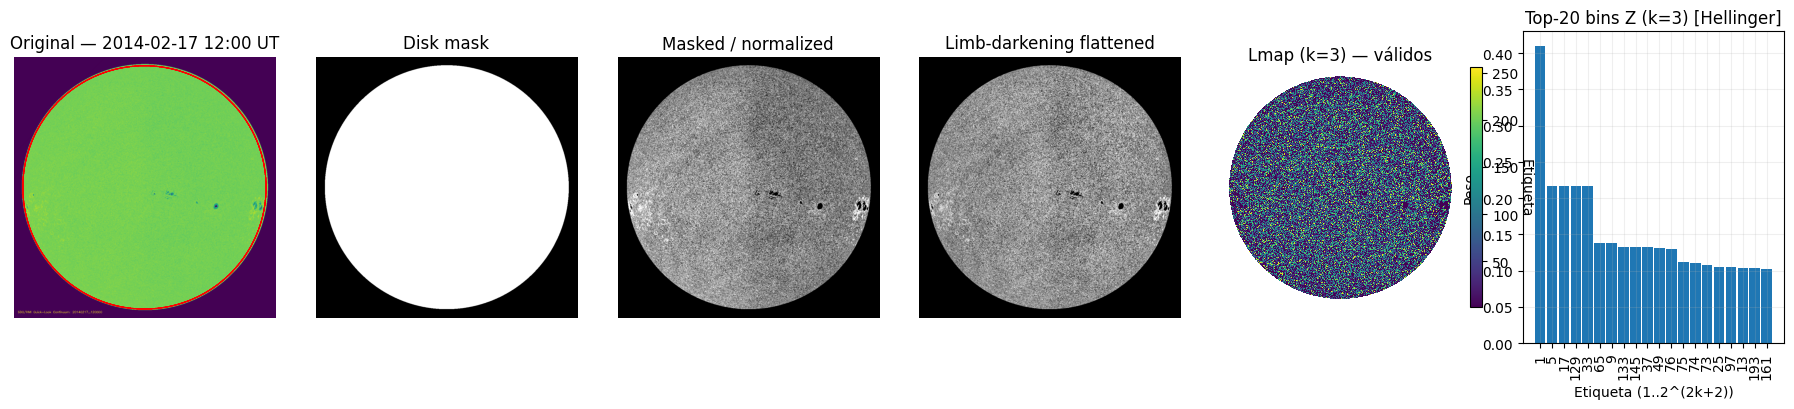

[OK] Figura guardada en: fig_hmi_ivg_20140217_k3.png


In [107]:
plot_hmi_multipanel(date(2014, 2, 17), orders=(3,), show_ld=True, top_bins=20)

In [182]:
# -------------------------------------------------------------
# Figura 2×3: Original • Máscara • Disco • (LD) • Lmap • Hist(Z_k)
# Requiere: fetch_hmi_image, solar_disk_mask, apply_mask,
#           patch_profile_visibility_vectorized,
#           limb_darkening_flatten, _valid_window_mask, _ivg_hist_masked
# -------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

def _compute_lmap_valid(A_float01, mask, k):
    _, Lmap = patch_profile_visibility_vectorized((A_float01*255).astype(np.uint8), order=k)
    valid_win = _valid_window_mask(mask, k)
    return Lmap, valid_win

def plot_hmi_grid_2x3(d: date,
                      k: int = 3,           # orden para Lmap + hist
                      show_ld: bool = True, # panel 4: limb-darkening flatten
                      hellinger: bool = True,
                      thresh: int = 8, margin: int = 2,
                      top_bins: int = 20,
                      cmap_img: str = "gray",
                      cmap_lmap: str = "viridis",
                      dpi: int = 300,
                      savepath: str | None = None,
                      show: bool = True):
    img = fetch_hmi_image(d)
    if img is None:
        raise RuntimeError(f"No se pudo descargar la imagen del {d}")

    # Máscara y disco normalizado
    mask = solar_disk_mask(img, thresh=thresh, margin=margin)
    A = apply_mask(img, mask, fill=0)  # float [0,1]

    # Disco flatten opcional
    A_ld = limb_darkening_flatten(A, mask, deg=4) if show_ld else A

    # Lmap + válidos sobre la imagen elegida (si hay LD, usamos A_ld)
    A_ref = A_ld if show_ld else A
    Lmap, valid = _compute_lmap_valid(A_ref, mask, k)
    Lvis = np.full_like(Lmap, np.nan, dtype=float)
    Lvis[valid] = Lmap[valid].astype(float)

    # Histograma Z_k (solo parches válidos)
    Zk = _ivg_hist_masked(A_ref, mask, order=k, hellinger=hellinger)
    idx = np.argsort(Zk)[::-1]
    top = idx[:top_bins]

    # ---- Layout 2×3 ----
    fig, axs = plt.subplots(2, 3, figsize=(15, 9))
    ax = axs.ravel()

    # (1) Original + contorno
    ax[0].imshow(img, cmap=None, vmin=0, vmax=255)
    ax[0].contour(mask, colors="r", linewidths=0.6)
    ax[0].set_title(f"Original — {d.isoformat()} 12:00 UT")
    #ax[0].axis("off")
    ax[0].text(12, 12, "(a)", fontsize=20, color='w', ha='left', va='top', fontweight="bold")

    # (2) Máscara
    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Disk mask")
    #ax[1].axis("off")
    ax[1].text(12, 12, "(b)", fontsize=20, color='w', ha='left', va='top', fontweight="bold")

    # (3) Disco normalizado
    ax[2].imshow(A, cmap=cmap_img, vmin=0, vmax=1)
    ax[2].set_title("Masked / normalized")
    #ax[2].axis("off")
    ax[2].text(12, 12, "(c)", fontsize=20, color='w', ha='left', va='top', fontweight="bold")

    # (4) Disco flatten (si show_ld=False, repite normalizado)
    ax[3].imshow(A_ld, cmap=cmap_img, vmin=0, vmax=1)
    ax[3].set_title("Limb-darkening flattened" if show_ld else "Masked / normalized")
    #ax[3].axis("off")
    ax[3].text(12, 12, "(d)", fontsize=20, color='w', ha='left', va='top', fontweight="bold")

    # (5) Lmap (solo ventanas válidas)
    im = ax[5].imshow(Lvis, cmap=cmap_lmap, interpolation="nearest")
    ax[5].set_title(f"Lmap (k={k}) — válidos")
    #ax[5].axis("off")
    ax[5].text(12, 12, "(f)", fontsize=20, color='k', ha='left', va='top', fontweight="bold")
    cbar = plt.colorbar(im, ax=ax[5], fraction=0.046, pad=0.01)
    cbar.ax.set_ylabel("Label", rotation=0, labelpad=-50, loc="top")

    # (6) Histograma Top-N
    ax[4].bar(np.arange(len(top)), Zk[top], width=0.9)
    ax[4].set_title(f"Top-{top_bins} bins Z (k={k})" + (" [Hellinger]" if hellinger else " [L1]"))
    ax[4].set_xticks(np.arange(len(top)))
    ax[4].set_xticklabels([str(int(b)) for b in (top+1)], rotation=90)
    ax[4].set_xlabel("Label (1..2^(2k+2))")
    ax[4].set_ylabel("Weight")
    ax[4].grid(alpha=0.1)
    ax[4].text(18.1, 0.425, "(e)", fontsize=20, color='k', ha='left', va='top', fontweight="bold")

    plt.tight_layout(h_pad=0.3,w_pad=0.3)
    if savepath is None:
        savepath = f"fig_hmi_ivg_{d.strftime('%Y%m%d')}_k{k}_2x3.png"
    fig.savefig(savepath, dpi=dpi, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close(fig)
    print(f"[OK] Figura guardada en: {savepath}")

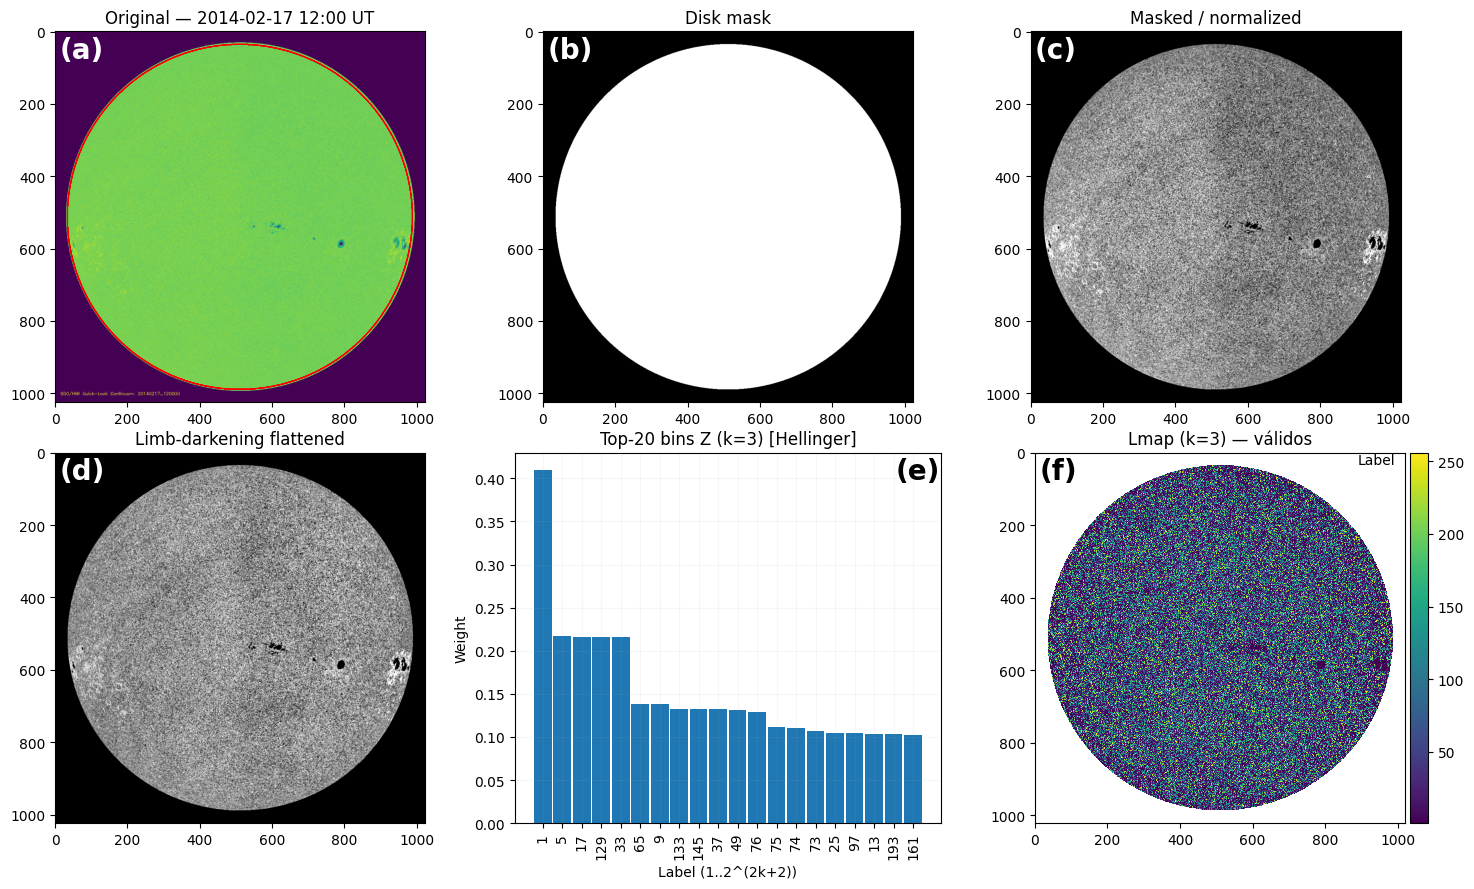

[OK] Figura guardada en: fig_hmi_ivg_20140217_k3_2x3.png


In [183]:
plot_hmi_grid_2x3(date(2014, 2, 17), k=3, show_ld=True, top_bins=20)